In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

import time
import ipdb

%matplotlib inline
%matplotlib notebook

In [5439]:
def get_edge(G, from_node, to_node):
    edge = edges.loc[(edges['from']==from_node)&(edges['to']==to_node)]
    return edge['EdgeName'].iloc[0]
def norm_vec(a):
    return (np.array(a) / np.linalg.norm(np.array(a))).flatten()

class rider:
    def __init__(self, config):
        # config is a dictionary
        self.ID = config['ID']                                  # scalar
        self.position = config['initial_position']              # 2-D array
        self.maxspeed = config['maxspeed']                      # scalar
        self.stop_time = 0                                      # scalar, float
        self.knowledge = None
        self.if_matched = False
        self.customer_nodes = []
        self.merchant_node = []
        
        closest_node_index = (((nodes.iloc[:, 1:] - self.position )**2).sum(axis=1)).idxmin()
        self.closest_node = nodes.loc[closest_node_index, 'NodeName']
        closest_node_position = nodes.loc[nodes['NodeName']==self.closest_node, ['x', 'y']].to_numpy().flatten()
        
        self.state = 'idle'                                     # string 'idle' or 'working' or 'stop'
        self.speed = self.maxspeed / 10
        if np.linalg.norm(closest_node_position - self.position) == 0:
            self.direction = norm_vec(np.random.rand(2))
        else:
            self.direction = norm_vec(closest_node_position - self.position)
        self.next_node = self.closest_node
        self.destination = np.nan
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])

    def update_knowledge(self, knowledge):
        self.knowledge = knowledge
        self.merchant_node = self.knowledge['merchant_node']     # scalar
        self.customer_nodes = self.knowledge['customer_nodes']   # 1-D array
        self.destination = self.merchant_node
        closest_node_index = (((nodes.iloc[:, 1:] - self.position )**2).sum(axis=1)).idxmin()
        self.closest_node = nodes.loc[closest_node_index, 'NodeName']
        closest_node_position = nodes.loc[nodes['NodeName']==self.closest_node, ['x', 'y']].to_numpy().flatten()
        if np.linalg.norm(closest_node_position - self.position) == 0:
            self.direction = norm_vec(np.random.rand(2))
        else:
            self.direction = norm_vec(closest_node_position - self.position)
        
        self.next_node = self.closest_node
        # first go to the closest node, then follow the path
        self.path = nx.dijkstra_path(
            self.knowledge['map'], self.next_node, self.destination
        )                                                       # list
        # next node is the last node, then the next next node is random
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)]) if self.next_node==self.path[-1] else self.path[1]
#         self.last_node = self.path[0]                           # scalar, node ID
#         self.next_node = self.path[1]                           # scalar, node ID
#         self.nextnext_node = self.path[self.path.index(self.next_node)+1]
#         self.edge = get_edge(
#             self.knowledge['map'], 
#             self.last_node, 
#             self.next_node
#         )
#         self.next_edge = get_edge(
#             self.knowledge['map'], 
#             self.next_node, 
#             self.nextnext_node
#         )
#         last_node_position = nodes.loc[nodes['NodeName']==self.last_node, ['x', 'y']].to_numpy()
#         next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy()
#         self.direction = norm_vec(next_node_position - last_node_position)

    
    def move(self, t_resolution, knowledge=None):
        # move one step foweard
        if self.state == 'idle':
            travel_distance_mag = self.speed * np.random.rand() * t_resolution
            if self.if_matched:
                self.state = 'working'
                self.speed = self.maxspeed
                self.update_knowledge(knowledge)
                
        elif self.state == 'working':
            travel_distance_mag = self.speed * t_resolution
        elif self.state == 'stop':
            self.stop()
            return
        
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        distance_to_next_node = np.linalg.norm(self.position - next_node_position)
        
        if travel_distance_mag < distance_to_next_node:
            self.position = self.position + travel_distance_mag * self.direction
        elif travel_distance_mag >= distance_to_next_node:
            self.position = next_node_position
            
            if self.next_node == self.destination:
                if self.stop_time==0:
                    if len(self.customer_nodes)==0:
                        # if no further customers, complete
                        self.stop()
                        self.complete()
                        return
                    
                    # update the next destination, path, next nodes, and direction (included in the update destination func)
                    # the next destination is the closest customer
                    ######################################################
                    # this place should be modified to VMT, not distance

                    next_destination_index = (((
                        nodes.loc[nodes['NodeName'].isin(self.customer_nodes), ['x', 'y']] - self.position
                    )**2).sum(axis=1)).idxmin()
                    
                    next_destination = nodes.loc[next_destination_index, 'NodeName']
                    self.customer_nodes.remove(next_destination)
                    self.update(next_destination)
                    
                self.stop()
                return
                
            exceed_distance = travel_distance_mag - distance_to_next_node
            nextnext_node_position = nodes.loc[nodes['NodeName']==self.nextnext_node, ['x', 'y']].to_numpy().flatten()
            self.direction = norm_vec(nextnext_node_position - next_node_position)
            
            self.position = self.position + exceed_distance * self.direction
            self.next_node = self.nextnext_node
            if self.knowledge==None:
                self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
            else:
                if self.next_node == self.path[-1]:
                    # next node is the last node, then the next next node is random
                    self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
                else:
                    self.nextnext_node = self.path[self.path.index(self.next_node)+1]

        
    def stop(self):
        # when pickup, dilivered, or else
        self.state = 'stop'
        if self.stop_time > 0.1:
            self.restart_working()
        else:
            self.stop_time = self.stop_time + t_resolution
    
    def restart_working(self):
        self.state = 'working'
        self.stop_time = 0
    
    def complete(self):
        # complete all orders in current bundle
        self.state = 'idle'
        self.customer_nodes = []
        self.destination = np.nan
        self.speed = self.maxspeed / 10
        self.if_matched = False
        self.next_node = np.random.choice([i for i in G.neighbors(self.next_node)])
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        self.direction = norm_vec(next_node_position - self.position)
        self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])
    
    def update(self, destination):
        # after arriving one destination
        self.destination = destination
        self.path = nx.dijkstra_path(self.knowledge['map'], self.next_node, self.destination)  # next_node is current location
        if len(self.path)==1:
            self.stop()
            if len(self.customer_nodes)==0:
                # if no further customers, complete
                self.complete()
                return
            next_destination_index = (((
                nodes.loc[nodes['NodeName'].isin(self.customer_nodes), ['x', 'y']] - self.position
            )**2).sum(axis=1)).idxmin()

            next_destination = nodes.loc[next_destination_index, 'NodeName']
            self.customer_nodes.remove(next_destination)
            self.update(next_destination)
            return
        self.next_node = self.path[1]
        # if only 2 nodes, then nextnext node is random
        self.nextnext_node = self.path[2] if len(self.path)>2 else np.random.choice([i for i in G.neighbors(self.next_node)])  
        next_node_position = nodes.loc[nodes['NodeName']==self.next_node, ['x', 'y']].to_numpy().flatten()
        self.direction = norm_vec(next_node_position - self.position)
    

In [5440]:
config_set = []
rider_set = []
knowledge_set = []
N = 10

for i in range(N):
    config_i = {
        'ID': i,
        'initial_position': np.array([np.random.randint(25), np.random.randint(25)]),
        'maxspeed': np.random.randint(15, 30)
    }
    rider_i = rider(config_i)
    k

    knowledge_i = {
        'map': G,
        'merchant_node': 15,
        'customer_nodes': list(np.random.randint(1, 36, size=np.random.randint(8)))
    }
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    knowledge_set.append(knowledge_i)
    
    

In [5441]:
knowledge_set[0]

{'map': <networkx.classes.graph.Graph at 0x20e3b49ea30>,
 'merchant_node': 15,
 'customer_nodes': [25, 30, 25]}

In [5442]:
r = 2
cR = 8
k = 1
t_resolution = 0.005

A_c = 25
color = np.random.rand(N)

def animate(n):
    idle_rider_ID = []
    for i in range(N):
        if rider_set[i].state=='idle':
            idle_rider_ID.append(rider_set[i].ID)
    
    p = 1 - np.exp(-np.pi*r**2*len(idle_rider_ID)/25)
    n_orders = 0
    for i in range(N):
        n_orders += len(knowledge_set[i]['customer_nodes'])
        
    pp = min(p * n_orders / k / len(idle_rider_ID), 1)
    pp = 0 if np.isnan(pp) else pp
    
    matched_rider_IDs = np.random.choice(idle_rider_ID, int(len(idle_rider_ID)*pp) )
    
    # move
    for i in range(N):
        if rider_set[i].ID in matched_rider_IDs:
            rider_set[i].if_matched = True
            rider_set[i].move(t_resolution, knowledge_set[i])
        else:
            rider_set[i].move(t_resolution)
    
    
    # order generation
#     for i in range(N):
#         knowledge_set[i]['customer_nodes'].extend( list(np.random.randint(1, 36, size=np.random.randint(2))) )
    
    scat.set_offsets(
        np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
    )
    scat.set_array(color)
      
    return scat
    

In [5447]:
animate(2)
print(rider_set[0].destination)
rider_set[0].path

nan


[25, 26, 27, 28, 29, 30]

In [5448]:
%debug

> c:\users\10169\appdata\local\temp\ipykernel_3376\2803356422.py(120)move()

ipdb> l
    115                 self.stop()
    116                 return
    117 
    118             exceed_distance = travel_distance_mag - distance_to_next_node
    119             nextnext_node_position = nodes.loc[nodes['NodeName']==self.nextnext_node, ['x', 'y']].to_numpy().flatten()
--> 120             self.direction = norm_vec(nextnext_node_position - next_node_position)
    121 
    122             self.position = self.position + exceed_distance * self.direction
    123             self.next_node = self.nextnext_node
    124             if self.knowledge==None:
    125                 self.nextnext_node = np.random.choice([i for i in G.neighbors(self.next_node)])

ipdb> nextnext_node_position 
array([], dtype=int64)
ipdb> self.nextnext_node
nan
ipdb> q


In [5445]:
rider_set[0].destination

15

<IPython.core.display.Javascript object>


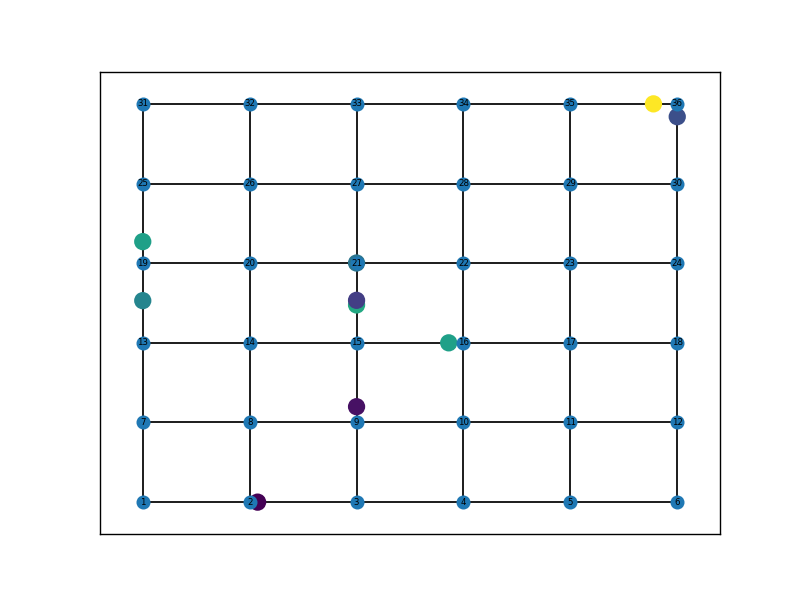

In [5446]:
# marking the x-axis and y-axis
fig, ax = plt.subplots()
  
nx.draw_networkx(G, pos=pos, ax=ax, node_size=50, font_size=5)

# initializing a line variable

scat = ax.scatter([], [], s=80)

ax.set_xlim(-2, 27)
ax.set_ylim(-2, 27)

anim = animation.FuncAnimation(fig, animate, 
                     frames = 200, interval = 1, blit = False)

plt.show()

# anim.save('continuousSineWave.mp4',
#           writer = 'ffmpeg', fps = 30)

In [4028]:
knowledge1

{'map': <networkx.classes.graph.Graph at 0x20e3b49ea30>,
 'merchant_node': 15,
 'customer_nodes': [14, 20, 27]}

In [74]:
np.array([[rider1.position[0], rider2.position[0]], [rider1.position[1], rider2.position[1]]])

array([[ 2.29249524, 25.        ],
       [ 0.        ,  7.22700467]])

<IPython.core.display.Javascript object>


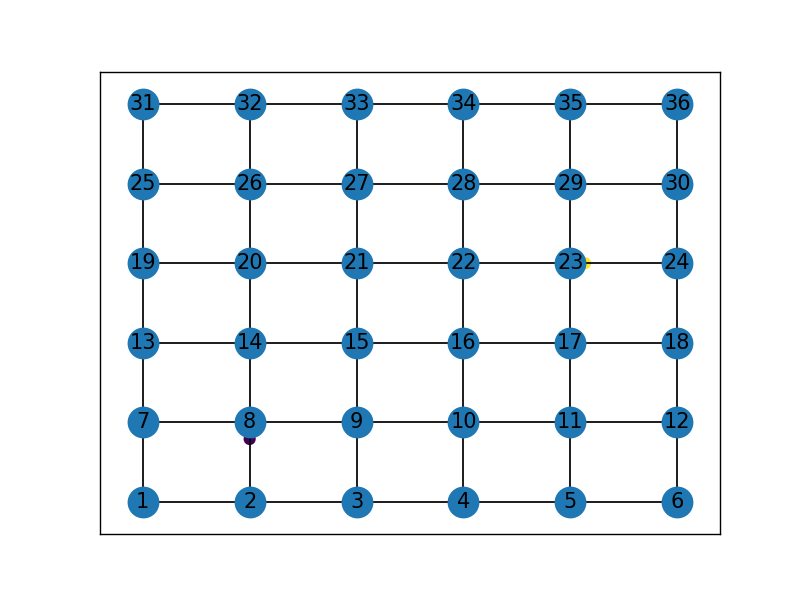

In [79]:
import itertools

np.random.seed(42)
frames = 40

x = np.arange(frames)
y = np.sin(x)
colors = itertools.cycle(['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet'])
data = [(np.random.uniform(-1, 1, 10) + x[i],
         np.random.uniform(-1, 1, 10) + y[i])
        for i in range(frames)]

fig, ax = plt.subplots()

s = ax.scatter([], [])

ax.set_xlim(-2, 27)
ax.set_ylim(-2, 27)
nx.draw_networkx(G, pos=pos)
def update(i):
    
    rider1.move(0.1)
    rider2.move(0.1)
    
    s.set_offsets(np.array([[rider1.position[0], rider2.position[0]], [rider1.position[1], rider2.position[1]]]).T)
    s.set_array(np.array([0.1, 0.5]))

ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
plt.show()

还需要一个rider knowledge

地图可以看成一个weighted graph

In [4]:
nodes = pd.read_csv('./data/node.csv')
edges = pd.read_csv('./data/edge.csv')

edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.sqrt(
        (from_node['x'].values[0] - to_node['x'].values[0])**2 + (from_node['y'].values[0] - to_node['y'].values[0])**2
    )
    
    

In [5]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

<IPython.core.display.Javascript object>


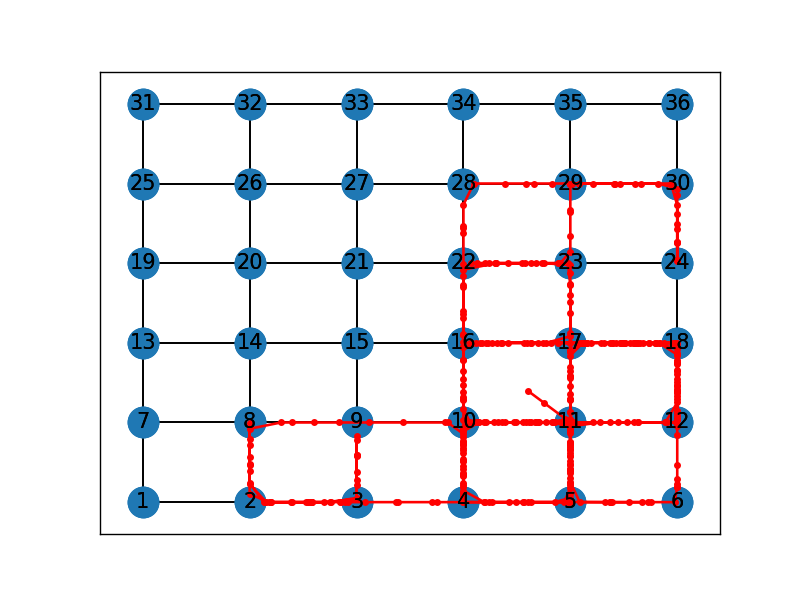

In [6]:
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos)

In [152]:
nx.dijkstra_path(G, 1, 15)

[1, 2, 3, 7, 11, 15]